# Recipe Maker

## Step1: Data Loading and Text Preprocessing 

In [2]:
import pandas as pd
import re
from collections import Counter

# Load the dataset
file_path = 'recipes.csv'
recipes_df = pd.read_csv(file_path)



In [3]:
# Manually define a set of stop words
stop_words = set([
    'a', 'an', 'the', 'and', 'or', 'in', 'of', 'to', 'with', 'on', 'for', 'at', 
    'by', 'from', 'up', 'down', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 
    'being', 'has', 'have', 'had', 'do', 'does', 'did', 'will', 'would', 'shall', 
    'should', 'can', 'could', 'may', 'might', 'must', 'that', 'this', 'these', 
    'those', 'it', 'its', 'he', 'she', 'they', 'them', 'his', 'her', 'their', 'there'
])

# Function to preprocess the text
def preprocess_text_without_nltk(text):
    # Convert to lower case
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the ingredients column
recipes_df['ingredients_cleaned'] = recipes_df['ingredients'].apply(preprocess_text_without_nltk)

# Display the first few rows to verify preprocessing
print(recipes_df[['recipe_name', 'ingredients', 'ingredients_cleaned']].head())


                   recipe_name  \
0     Apple-Cranberry Crostada   
1    Apple Pie by Grandma Ople   
2  Sarah's Homemade Applesauce   
3                  Apple Crisp   
4            Apple Pie Filling   

                                         ingredients  \
0  3 tablespoons butter, 2 pounds Granny Smith ap...   
1  8 small Granny Smith apples, or as needed, ½ c...   
2  4  apples - peeled, cored and chopped, ¾ cup w...   
3  10 cups all-purpose apples, peeled, cored and ...   
4  18 cups thinly sliced apples, 3 tablespoons le...   

                                 ingredients_cleaned  
0  tablespoons butter pounds granny smith apples ...  
1  small granny smith apples as needed cup unsalt...  
2  apples peeled cored chopped cup water cup whit...  
3  cups allpurpose apples peeled cored sliced cup...  
4  cups thinly sliced apples tablespoons lemon ju...  


## Step2: EDA

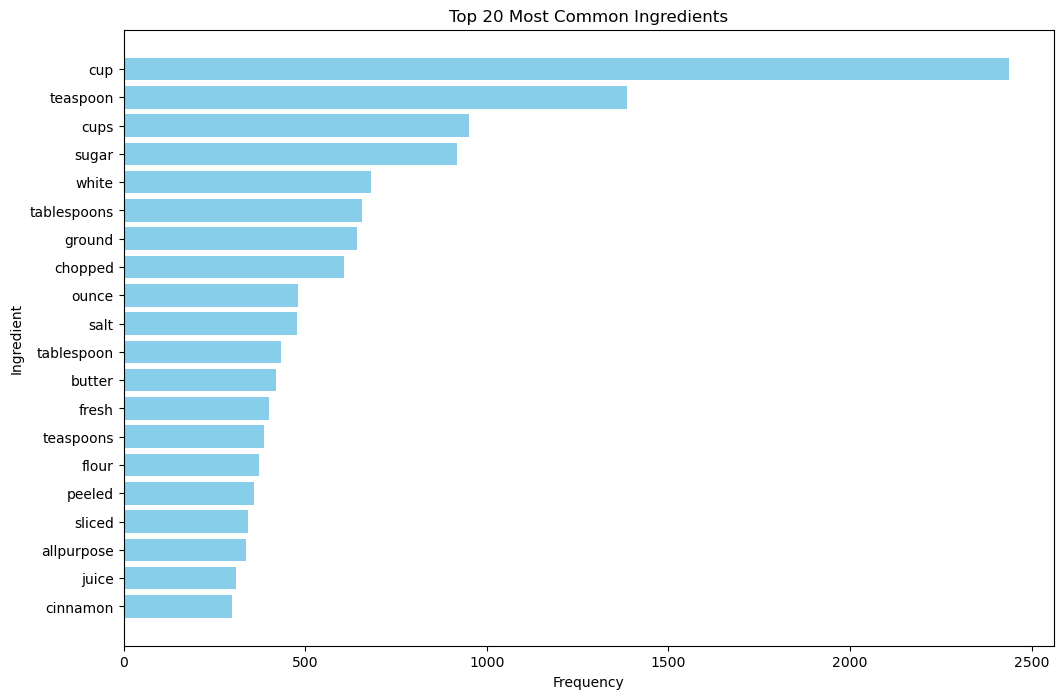

In [4]:
import matplotlib.pyplot as plt

# Function to count ingredient frequency
def get_ingredient_frequency(ingredients_list):
    all_ingredients = ' '.join(ingredients_list).split()
    return Counter(all_ingredients)

# Get ingredient frequency
ingredient_frequency = get_ingredient_frequency(recipes_df['ingredients_cleaned'])

# Convert to DataFrame for better visualization
ingredient_freq_df = pd.DataFrame(ingredient_frequency.items(), columns=['ingredient', 'frequency'])
ingredient_freq_df = ingredient_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Plot the top 20 most common ingredients
plt.figure(figsize=(12, 8))
plt.barh(ingredient_freq_df['ingredient'][:20], ingredient_freq_df['frequency'][:20], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.title('Top 20 Most Common Ingredients')
plt.gca().invert_yaxis()
plt.show()


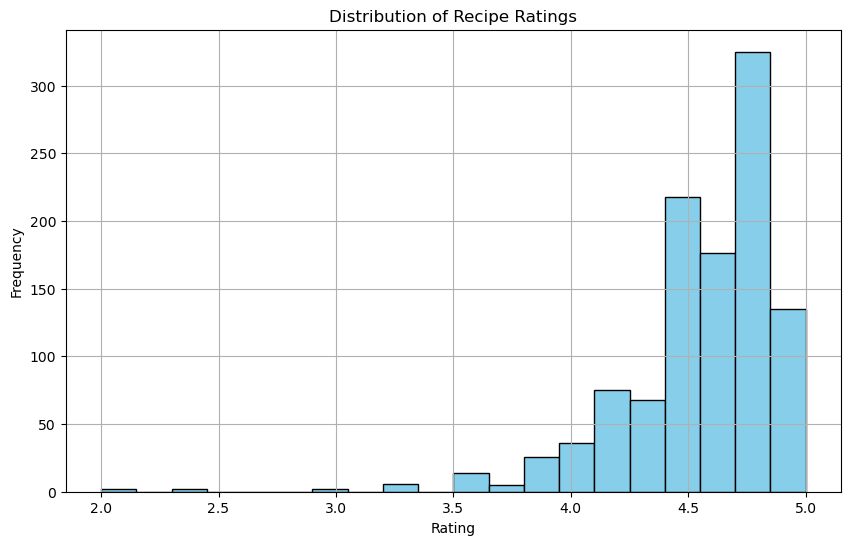

In [5]:
# Distribution of recipe ratings
plt.figure(figsize=(10, 6))
recipes_df['rating'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Recipe Ratings')
plt.show()


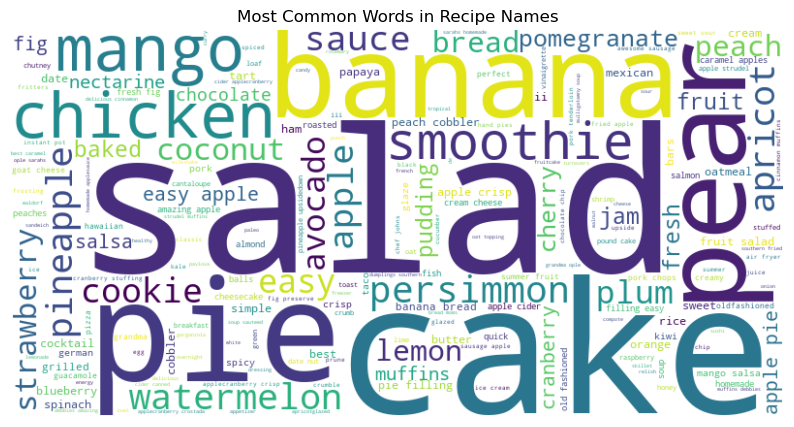

In [6]:
# Most common words
from wordcloud import WordCloud

# Function to preprocess recipe names
def preprocess_recipe_name(name):
    name = name.lower()
    name = re.sub(r'[^a-z\s]', '', name)
    tokens = name.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to recipe names
recipes_df['recipe_name_cleaned'] = recipes_df['recipe_name'].apply(preprocess_recipe_name)

# Generate a word cloud for the recipe names
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(recipes_df['recipe_name_cleaned']))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Recipe Names')
plt.show()


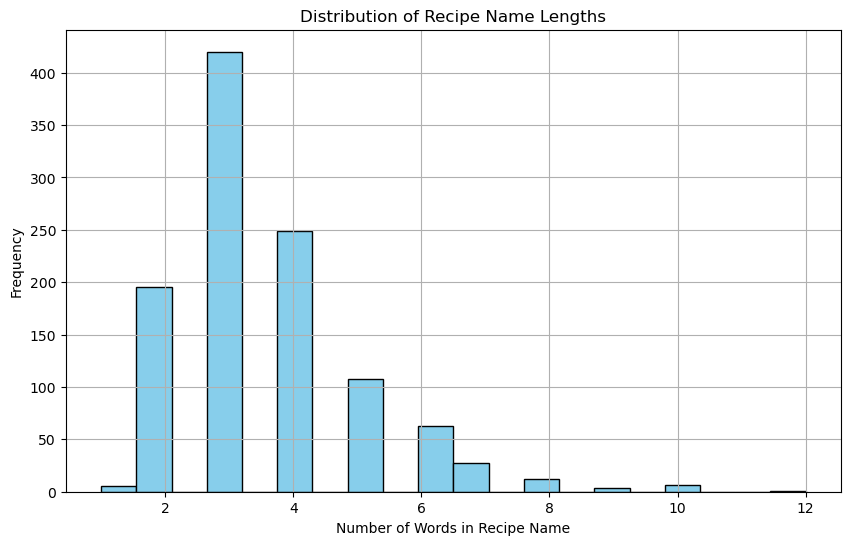

In [7]:
# Length of recipe names
recipes_df['recipe_name_length'] = recipes_df['recipe_name'].apply(lambda x: len(x.split()))

# Distribution of recipe name lengths
plt.figure(figsize=(10, 6))
recipes_df['recipe_name_length'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words in Recipe Name')
plt.ylabel('Frequency')
plt.title('Distribution of Recipe Name Lengths')
plt.show()


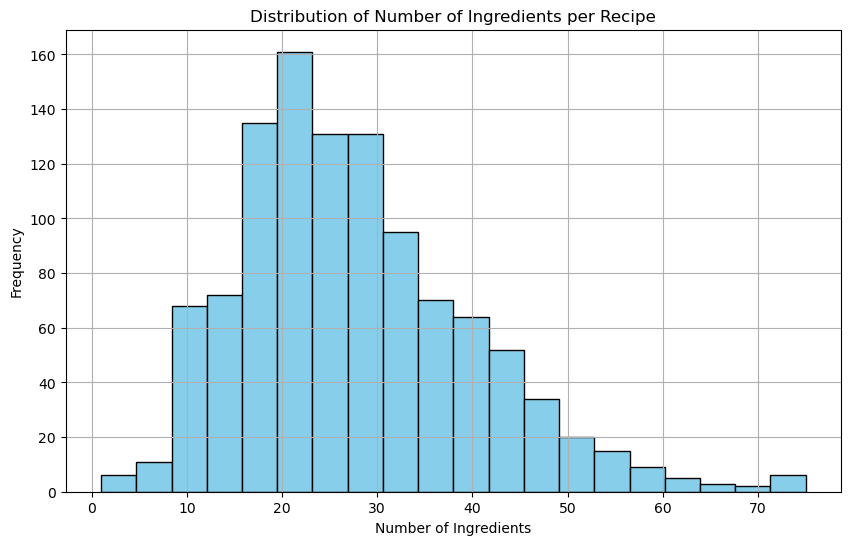

In [8]:
# Number of ingredients per recipe
recipes_df['num_ingredients'] = recipes_df['ingredients_cleaned'].apply(lambda x: len(x.split()))

# Distribution of number of ingredients per recipe
plt.figure(figsize=(10, 6))
recipes_df['num_ingredients'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ingredients per Recipe')
plt.show()


## Step3: Feature Extraction

In [9]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the cleaned ingredients using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recipes_df['ingredients_cleaned'])

print(tfidf_matrix.shape)  # (number of recipes, number of unique ingredients)

(1090, 1190)


In [10]:
tfidf_matrix

<1090x1190 sparse matrix of type '<class 'numpy.float64'>'
	with 24319 stored elements in Compressed Sparse Row format>

## Step4: Recommendation System

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to recommend recipes based on input ingredients
def recommend_recipes(input_ingredients, n_recommendations=5):
    # Preprocess the input ingredients
    input_ingredients_cleaned = preprocess_text_without_nltk(input_ingredients)
    # Vectorize the input ingredients
    input_vec = tfidf_vectorizer.transform([input_ingredients_cleaned])
    # Compute cosine similarity between input and all recipes
    cosine_similarities = cosine_similarity(input_vec, tfidf_matrix).flatten()
    # Get the indices of the top n most similar recipes
    similar_indices = cosine_similarities.argsort()[-n_recommendations:][::-1]
    # Get the recommended recipe names
    recommended_recipes = recipes_df['recipe_name'].iloc[similar_indices]
    return recommended_recipes

# Example usage
input_ingredients = "apple, sugar, flour, butter"
recommended_recipes = recommend_recipes(input_ingredients)
print(recommended_recipes)


131            Veronica's Apple Pancakes
642     Fresh Fruit Tart with Mascarpone
58     Easy Apple Crisp with Pie Filling
120    Easy Apple Crisp with Pie Filling
89     Easy Apple Crisp with Pie Filling
Name: recipe_name, dtype: object


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to recommend recipes based on input ingredients
def recommend_recipes(input_ingredients, n_recommendations=5):
    # Preprocess the input ingredients
    input_ingredients_cleaned = preprocess_text_without_nltk(input_ingredients)
    # Vectorize the input ingredients
    input_vec = tfidf_vectorizer.transform([input_ingredients_cleaned])
    # Compute cosine similarity between input and all recipes
    cosine_similarities = cosine_similarity(input_vec, tfidf_matrix).flatten()
    # Get the indices of the top n most similar recipes
    similar_indices = cosine_similarities.argsort()[-n_recommendations:][::-1]
    # Get the recommended recipe names
    recommended_recipes = recipes_df['recipe_name'].iloc[similar_indices].tolist()
    return recommended_recipes

# Example usage
input_ingredients = "apple, sugar, flour, butter"
recommended_recipes = recommend_recipes(input_ingredients)
print(recommended_recipes)


["Veronica's Apple Pancakes", 'Fresh Fruit Tart with Mascarpone', 'Easy Apple Crisp with Pie Filling', 'Easy Apple Crisp with Pie Filling', 'Easy Apple Crisp with Pie Filling']


# Weather Updation
Generating data according to weather

In [14]:
# Load the dataset
import random
file_path = 'recipes.csv'
recipes_df = pd.read_csv(file_path)

# Define possible weather conditions
weather_conditions = ['hot', 'cold', 'rainy', 'sunny']

# Function to randomly assign weather conditions to recipes
def assign_weather_condition(recipe_name):
    # Example logic: certain keywords in recipe names might influence the weather condition
    if any(word in recipe_name.lower() for word in ['soup', 'stew', 'chili', 'bake']):
        return 'cold'
    elif any(word in recipe_name.lower() for word in ['salad', 'smoothie', 'ice', 'cold']):
        return 'hot'
    elif any(word in recipe_name.lower() for word in ['cake', 'cookie', 'pie']):
        return 'rainy'
    else:
        return random.choice(weather_conditions)

# Apply the function to create a new column for weather conditions
recipes_df['weather_condition'] = recipes_df['recipe_name'].apply(assign_weather_condition)

# Save the new dataset to a CSV file
weather_recipe_dataset_path = 'weather_recipes.csv'
recipes_df.to_csv(weather_recipe_dataset_path, index=False)

# Display the first few rows of the new dataset
print(recipes_df[['recipe_name', 'weather_condition']].head())


                   recipe_name weather_condition
0     Apple-Cranberry Crostada              cold
1    Apple Pie by Grandma Ople             rainy
2  Sarah's Homemade Applesauce             rainy
3                  Apple Crisp             rainy
4            Apple Pie Filling             rainy


### Implement Weather-Based Recipe Recommendation


In [17]:
# Function to recommend recipes based on weather condition
def recommend_recipes_based_on_weather(weather_condition, n_recommendations=5):
    # Filter recipes by the given weather condition
    filtered_recipes = recipes_df[recipes_df['weather_condition'] == weather_condition]
    # Randomly select n recommendations from the filtered recipes
    recommended_recipes = filtered_recipes['recipe_name'].sample(n=n_recommendations)
    return recommended_recipes

# Example usage
weather_condition = 'rainy'
recommended_recipes_weather = recommend_recipes_based_on_weather(weather_condition)
print(recommended_recipes_weather)


552               Persimmon Cheesecake
968                 Earthquake Cake II
281    Watermelon-Cucumber Agua Fresca
285                   Cantaloupe Pie I
337                 Easy Lemon Cookies
Name: recipe_name, dtype: object
